In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
max_degree = 5
n_samples = 6
X = torch.linspace(1,n_samples,n_samples).reshape(-1,1) # Column Vector: 50 x 1 shape
exponents = torch.arange(0,max_degree+1).reshape(1,-1).type(torch.float) # It must be type torch.float to be used in pow
poly_X = torch.pow(X,exponents) # 50 x max_degree size
poly_X_norm = torch.ones_like(poly_X)
poly_X_norm[:,1:] = (poly_X[:,1:] - torch.mean(poly_X[:,1:],dim = 0)) / torch.std(poly_X[:,1:], dim = 0) # Normalize to not diverge, lr reasonably size
true_w = torch.zeros(max_degree+1)
true_w[:3] = torch.FloatTensor([2,2,-1])#,-1.6,-1.35])
true_w = true_w.reshape(-1,1)
y_without_noise = torch.mm(poly_X_norm,true_w)
print(poly_X_norm)
print(y_without_noise)
print(poly_X_norm.numpy() @ np.linalg.inv(poly_X_norm.numpy()))

tensor([[ 1.0000, -1.3363, -1.0590, -0.8696, -0.7474, -0.6663],
        [ 1.0000, -0.8018, -0.8347, -0.7856, -0.7178, -0.6561],
        [ 1.0000, -0.2673, -0.4610, -0.5577, -0.5893, -0.5869],
        [ 1.0000,  0.2673,  0.0623, -0.1139, -0.2434, -0.3309],
        [ 1.0000,  0.8018,  0.7350,  0.6177,  0.4859,  0.3578],
        [ 1.0000,  1.3363,  1.5573,  1.7091,  1.8121,  1.8824]])
tensor([[0.3864],
        [1.2311],
        [1.9264],
        [2.4722],
        [2.8685],
        [3.1153]])
[[ 1.0000153e+00  0.0000000e+00 -6.1035156e-05 -6.1035156e-05
   0.0000000e+00  0.0000000e+00]
 [-7.6293945e-06  9.9996948e-01  0.0000000e+00 -6.1035156e-05
   0.0000000e+00  0.0000000e+00]
 [-7.6293945e-06  0.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  7.6293945e-06]
 [ 0.0000000e+00  7.6293945e-06  0.0000000e+00  1.0000000e+00
   0.0000000e+00  9.5367432e-07]
 [ 0.0000000e+00  0.0000000e+00  6.1035156e-05 -3.0517578e-05
   9.9998474e-01 -1.9073486e-06]
 [-1.5258789e-05  0.0000000e+00

In [3]:
e = torch.randint(-1*max_degree,1*max_degree,(n_samples,1),dtype=torch.float)
y = y_without_noise + 0.001*e
y

tensor([[0.3884],
        [1.2341],
        [1.9284],
        [2.4712],
        [2.8665],
        [3.1163]])

In [4]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [5]:
torch.manual_seed(234)
model = Model(max_degree + 1, 1) 
print(model)
print('Weight:', model.linear.weight)
print('Bias:  ', model.linear.bias.item())

Model(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)
Weight: Parameter containing:
tensor([[ 0.3492,  0.0667, -0.3297, -0.4071,  0.0608,  0.1737]],
       requires_grad=True)
Bias:   -0.11055880784988403


In [6]:
criterion = nn.MSELoss()

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [8]:
def train_and_get_losses(model, epochs = 1000, print_partial = False):
    epochs = epochs
    losses = []
    print_partial = print_partial

    for i in range(epochs):
        i+=1
        y_pred = model.forward(poly_X_norm)
        loss = criterion(y_pred, y)
        losses.append(loss)
        if print_partial:
            print(f'epoch: {i:2}  loss: {loss.item():10.8f} weight: {model.linear.weight}  \
            bias: {model.linear.bias.item():10.8f}') 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Last differences:{y_pred - y}")
    return (losses,model)

Last differences:tensor([[ 0.0062],
        [-0.0103],
        [ 0.0004],
        [ 0.0064],
        [-0.0029],
        [ 0.0002]], grad_fn=<SubBackward0>)
linear.weight 	 Parameter containing:
tensor([[ 1.2303,  1.7367, -0.1736, -0.6997, -0.1376,  0.2712]],
       requires_grad=True)
linear.bias 	 Parameter containing:
tensor([0.7706], requires_grad=True)


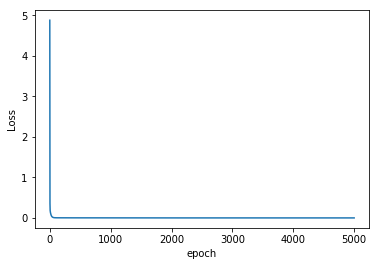

In [9]:
epochs = 5000
(losses,model) = train_and_get_losses(model,epochs = epochs)
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');
for name, param in model.named_parameters():
    print(name, '\t', param) 

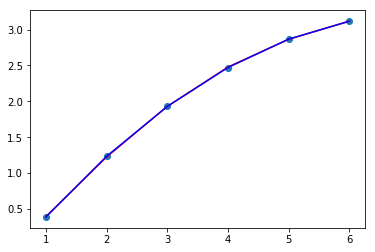

In [10]:
y_pred = model.forward(poly_X_norm)
y_pred_analytic = poly_X_norm.numpy() @ np.linalg.inv(poly_X_norm.numpy())@ y.numpy()
plt.scatter(X[:,0].numpy(), y.numpy())
plt.plot(X[:,0].numpy(), y_pred.detach().numpy(),'r') # By default connects the 2 dots with a 'r'ed line
plt.plot(X[:,0].numpy(), y_pred_analytic,'b') 